In [18]:
from deep_frecker import DeepFrecker, FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from fnet import MaskLoss, Conv3DStack


In [19]:
file = r"C:\Users\lucyc\Desktop\freckers_data\P1.h5"

# file_base_path = r"C:\Users\lucyc\Desktop\freckers_data\New_Fix_v"
# versions = ["2", "3", "4", "5", "6"]

# datasets = [FreckerDataSet(file_base_path + v + ".h5") for v in versions]

# # 合并两个数据集
# dataset = torch.utils.data.ConcatDataset(datasets)

dataset = FreckerDataSet(file_path=file)

# 按照顺序分割数据集
train_size = int(0.8 * len(dataset))  # 50% 用于训练
val_size = len(dataset) - train_size  # 50% 用于验证

# 使用 Subset 分割数据集
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataset, _ = random_split(train_dataset, [int(0.3 * len(train_dataset)), len(train_dataset) - int(0.3 * len(train_dataset))])
val_dataset, _ = random_split(val_dataset, [int(0.3 * len(val_dataset)), len(val_dataset) - int(0.3 * len(val_dataset))])
# 随机分割
# train_dataset, val_dataset = random_split(dataset, [int(0.5 * len(dataset)), len(dataset) - int(0.5 * len(dataset))])
# print(f"合并后的数据集大小: {len(train_dataset)}")

# # 定义训练集和验证集的大小
# train_size = int(0.8 * len(dataset))  # 80% 用于训练
# val_size = len(dataset) - train_size  # 20% 用于验证

# # 使用 random_split 分割数据集
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 128
shuffle = True
num_workers = 2

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)


In [34]:

train_dataset[3][0][-4:]

tensor([[[0., 0., 0., 0., 1., 0., 0., 1.],
         [0., 1., 1., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 1., 0., 0.],
         [0., 1., 0., 1., 1., 1., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 0., 1., 0., 1., 0.],
       

In [3]:
model = Conv3DStack()

In [4]:
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")



Epoch 1, Training Loss: 2.09272671, Validation Loss: 2.15630007
Epoch 2, Training Loss: 1.63002515, Validation Loss: 2.11550570
Epoch 3, Training Loss: 1.38778794, Validation Loss: 2.07148552


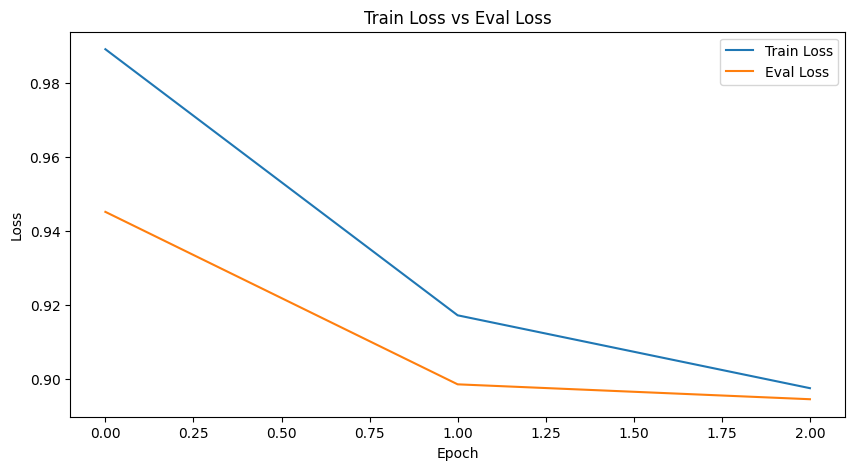

In [90]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [91]:
torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\ITER_v2.pth")

In [101]:
import torch
from fnet import MaskLoss, Conv3DStack
model = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\ITER_v2.pth", weights_only=False)
model2 = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\S1.pth", weights_only=False)
#model2 = Conv3DStack()

In [102]:
from mcts import mcts_data_collect
class MctsConfig:
    def __init__(self) -> None:
        self.c = 1.5
        self.t = 1
        self.finish = False
        self.visulze = False
        self.small = 0.0000001

        self.dirichlet_alpha = 0.03
        self.dirichlet_epsilon = 0.25

mcts_data_collect(model, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 30, 100, model2)

线程 1 第 0 轮游戏  第 0 步 模拟进行中

Rounds:  1
🟢🔴🔴🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🔵🟢🟢⚪
🟢🔵🔵🔵⚪🔵🔵🟢
move action:  (7, 4, 6, 4, False)
线程 1 第 0 轮游戏  第 1 步 模拟进行中

Rounds:  2
🟢🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🔴🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🔵🟢🟢⚪
🟢🔵🔵🔵⚪🔵🔵🟢
move action:  (0, 2, 1, 3, False)
线程 1 第 0 轮游戏  第 2 步 模拟进行中

Rounds:  3
🟢🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🔴🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🔵🟢🔵🟢🟢⚪
🟢⚪🔵🔵⚪🔵🔵🟢
move action:  (7, 1, 6, 2, False)
线程 1 第 0 轮游戏  第 3 步 模拟进行中

Rounds:  4
🟢🔴⚪🔴🔴🔴🔴🟢
⚪🟢🔴⚪🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🔵🟢🔵🟢🟢⚪
🟢⚪🔵🔵⚪🔵🔵🟢
move action:  (1, 3, 1, 2, False)
线程 1 第 0 轮游戏  第 4 步 模拟进行中

Rounds:  5
🟢🔴⚪🔴🔴🔴🔴🟢
⚪🟢🔴⚪🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🔵🔵⚪🟢🟢⚪
🟢⚪🔵🔵⚪🔵🔵🟢
move action:  (6, 4, 6, 3, False)
线程 1 第 0 轮游戏  第 5 步 模拟进行中

Rounds:  6
🟢🔴⚪🔴🔴🔴⚪🔴
⚪🟢🔴⚪🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🔵🔵⚪🟢🟢⚪
🟢⚪🔵🔵⚪🔵🔵🟢
move action:  (0, 6, 0, 7, False)
线程 1 第 0 轮游戏  第 6 步 模拟进行中

Rounds:  7
🟢🔴⚪🔴🔴🔴⚪🔴
⚪🟢🔴⚪🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🔵⚪🔵⚪🟢🟢⚪
🟢⚪🔵🔵⚪🔵🔵🟢
move action:  (6, 2, 6, 1,

KeyboardInterrupt: 

In [ ]:
import threading
import time
from mcts import mcts_data_collect

#(model, thread_num, file, rounds=100, sim_step=300)
# 创建多个线程
threads = []
for i in range(8):
    thread = threading.Thread(target=mcts_data_collect, 
            args=(model, i+1, f"C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_1.h5", 30, 500))
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()


In [12]:
torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_2_no_inverse.pth")